# Imports

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

# Visualization

In [40]:
data_path = '/content/drive/MyDrive/BAUM/Временной ряд.xlsx'
data = pd.read_excel(data_path, header=1, index_col='Data')
data.head()

,Y5401,Y5402,Y5707,Y5708,Y5403,Y5404,Y5705,Y5706,P596_1,P596_2,...,T5405_2,rezz5,rezz12,T5704_1,E5311,E5312,E5313,F571,F542,P545
Data,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,2.7011,1.1081,2.0384,5.5966,6.6993,0.0250,0.6627,4.9332,0.89,0.90,...,61.1,64.5,61.6,62.8,0.3,155.8,105.8,104.0,5458,3.16
2021-09-01 01:00:00,2.6752,1.1393,2.0170,5.4657,6.6271,0.0239,0.6319,4.8507,0.89,0.90,...,60.9,64.2,61.4,62.5,0.3,155.4,105.2,103.9,5432,3.20
2021-09-01 02:00:00,2.7369,1.1592,2.0199,5.4362,6.6754,0.0239,0.7912,5.0239,0.89,0.90,...,60.8,63.9,61.4,62.0,0.3,155.3,104.8,104.0,5341,3.33
2021-09-01 03:00:00,2.3622,1.1715,1.8657,5.1322,6.2127,0.0238,0.7474,4.5707,0.88,0.89,...,60.5,63.6,61.1,61.8,0.3,155.7,106.6,101.5,5364,3.18
2021-09-01 04:00:00,2.0537,1.2659,1.7712,4.8774,5.6731,0.0236,0.6387,4.0362,0.87,0.87,...,60.0,63.3,60.4,61.4,0.3,157.4,110.2,98.6,5273,3.16


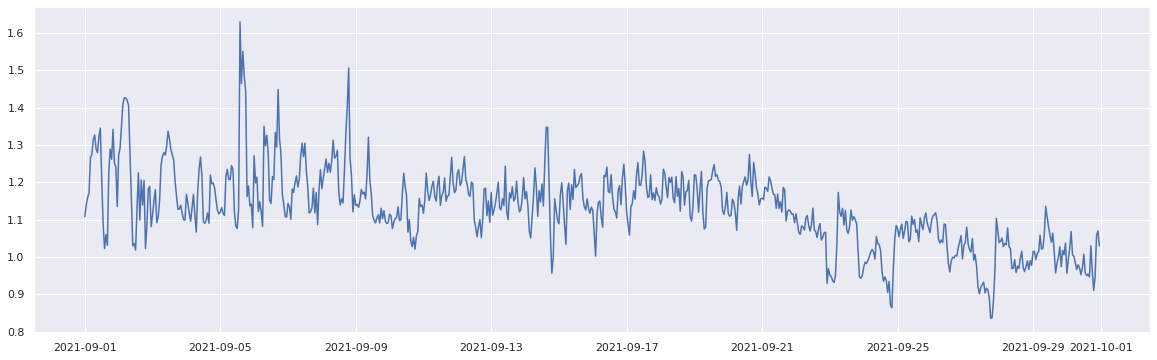

In [41]:
plt.figure(figsize=(20, 6))
plt.plot(data[['Y5402 ']]);

In [42]:
def plotMovingAverage(series: pd.Series, n: int) -> None:

    """
    Plot creating function

    series - pandas Series with timeseries
    n - rolling window size, n=1 - 1 hour
    """

    rolling_mean = series.rolling(window=n).mean()

    plt.figure(figsize=(28,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


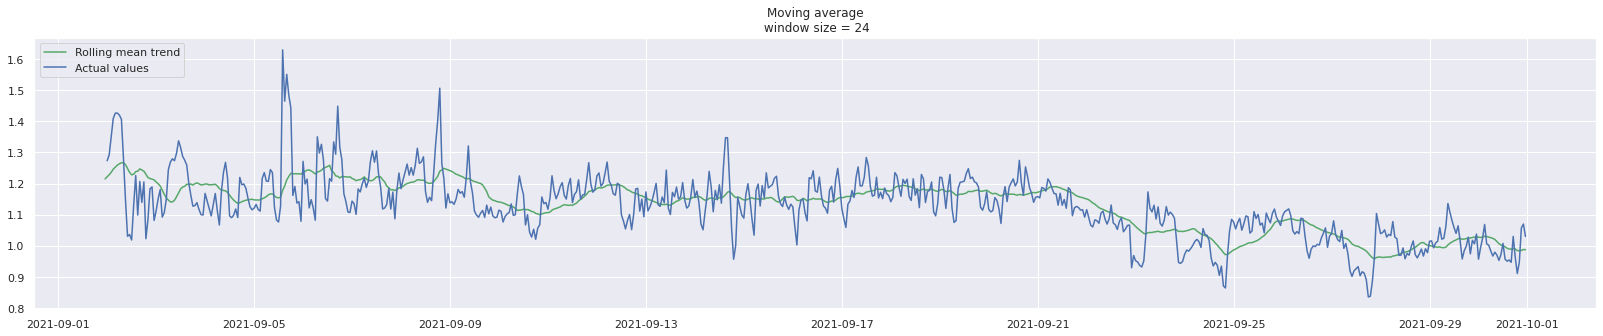

In [43]:
plotMovingAverage(data['Y5402 '], 24)

# Feature engineering

In [44]:
time_series = data[['Y5402 ']]
time_series.columns = ['y']

In [45]:
time_series['hour'] = time_series.index.hour
time_series['weekday'] = time_series.index.weekday
time_series['is_weekend'] = time_series.index.weekday.isin([5, 6]).astype(int)
time_series

,y,hour,weekday,is_weekend
Data,,,,
2021-09-01 00:00:00,1.1081,0,2,0
2021-09-01 01:00:00,1.1393,1,2,0
2021-09-01 02:00:00,1.1592,2,2,0
2021-09-01 03:00:00,1.1715,3,2,0
2021-09-01 04:00:00,1.2659,4,2,0
...,...,...,...,...
2021-09-30 19:00:00,0.9110,19,3,0
2021-09-30 20:00:00,0.9474,20,3,0
2021-09-30 21:00:00,1.0575,21,3,0


In [46]:
train_set, test_set= np.split(time_series, [int(0.85 *len(data))])

In [47]:
train_set = pd.get_dummies(train_set, columns=['weekday'])
test_set = pd.get_dummies(test_set, columns=['weekday'])

In [48]:
train_set['rolling_mean_24'] = train_set.y.rolling(window=24).mean().fillna(train_set.y.head(23).mean())
test_set['rolling_mean_24'] = test_set.y.rolling(window=24).mean().fillna(test_set.y.head(23).mean())

In [49]:
scaler = StandardScaler().fit(train_set.hour.values.reshape(-1, 1))
train_set.hour = scaler.transform(train_set.hour.values.reshape(-1, 1))

In [50]:
test_set.hour = scaler.transform(test_set.hour.values.reshape(-1, 1))

In [51]:
X_train, y_train = train_set.drop(columns=['y']), train_set.y
X_test, y_test = test_set.drop(columns=['y']), test_set.y

In [52]:
X_test['weekday_4'] = 0
X_test['weekday_5'] = 0

# Machine learning

In [53]:
reg_model = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=4
).fit(X_train, y_train)

In [54]:
reg_model.score(X_train, y_train)

0.9542049946144099

In [55]:
reg_model.score(X_test, y_test)

-1.002835399842387

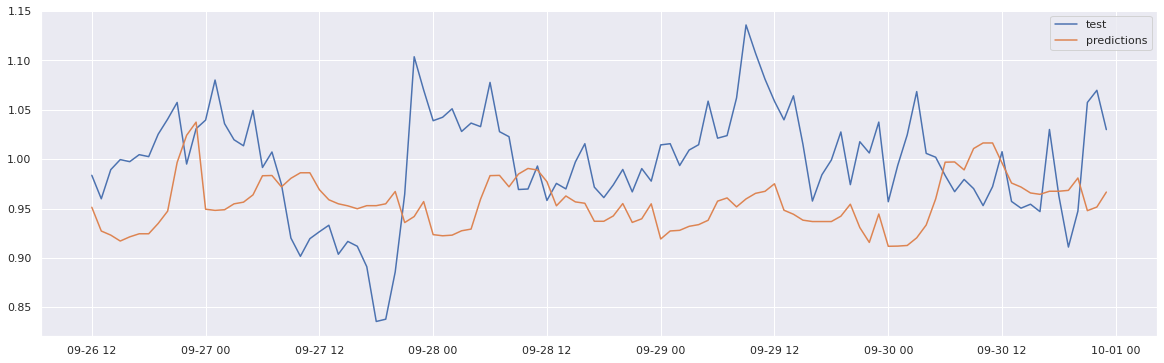

In [56]:
plt.figure(figsize=(20, 6))

plt.plot(y_test, label="test")
plt.plot(
    pd.DataFrame(reg_model.predict(X_test), index=y_test.index), 
    label="predictions")
plt.legend()

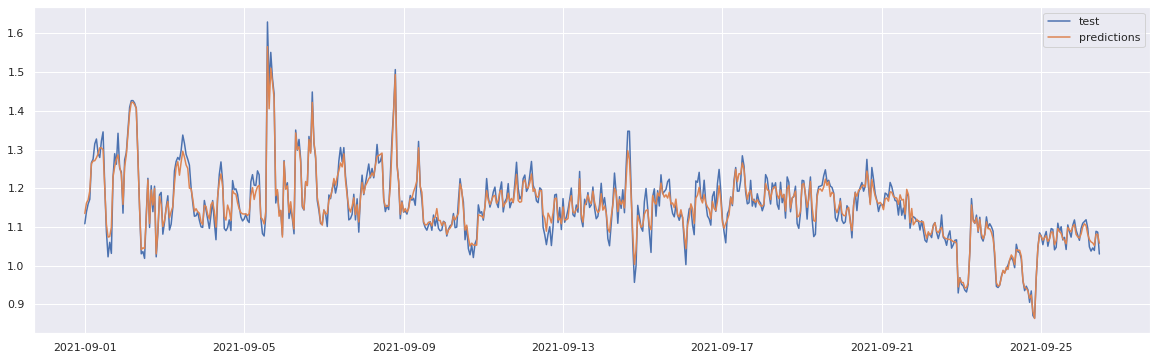

In [35]:
plt.figure(figsize=(20, 6))
plt.plot(y_train, label="train")
plt.plot(
    pd.DataFrame(reg_model.predict(X_train), index=y_train.index), 
    label="predictions")
plt.legend()